# Floating Point Conversion and Quantization Demo

This notebook demonstrates the usage of floating-point conversion and weight quantization functionality.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Type, Union, Dict, Optional
from hardware_accelerators.dtypes import *


def convert_float_type(value: BaseFloat, target_type: Type[BaseFloat]) -> BaseFloat:
    """
    Convert between different floating point types.
    This performs a direct bit-level conversion by truncating or extending the mantissa.

    Args:
        value: Source floating point value
        target_type: Target floating point type class

    Returns:
        Converted value in target type
    """
    # Instead of bit manipulation, we'll use the actual float value for conversion
    # This ensures proper handling of exponent bias differences
    float_val = float(value)
    return target_type(float_val)


def quantize_weights(
    weights: np.ndarray,
    target_type: Type[BaseFloat],
    scale_factor: Optional[float] = None,
    per_channel: bool = False,
) -> Union[np.ndarray, Dict[str, np.ndarray]]:
    """
    Quantize weights to target floating point type with optional scaling.

    Args:
        weights: Input weight tensor
        target_type: Target floating point type class
        scale_factor: Optional scaling factor. If None, will be computed automatically
        per_channel: Whether to compute scale factors per output channel

    Returns:
        If per_channel is False and scale_factor is None:
            Quantized weights array
        Otherwise:
            Dict containing:
                'weights': Quantized weights array
                'scales': Scale factors per channel (if per_channel=True)
                'scale': Single scale factor (if per_channel=False and scale_factor is not None)
    """
    # Create temporary instance to get format spec
    temp_target = target_type(0.0)
    format_spec = temp_target.format_spec()

    def quantize_array(arr, scale):
        """Helper function to quantize an array with a given scale factor"""
        scaled = arr / scale
        # Vectorize the quantization operation
        return np.array([float(target_type(float(x))) for x in scaled.flat]).reshape(
            scaled.shape
        )

    if per_channel:
        # Compute per-channel scale factors
        if scale_factor is not None:
            raise ValueError("Cannot specify scale_factor when per_channel=True")

        # For 2D weight matrices: (output_features, input_features)
        # For 4D conv weights: (output_channels, input_channels, height, width)
        # We want to scale per output channel/feature, so use axis=1 for remaining dims
        if weights.ndim == 4:
            max_vals = np.max(
                np.abs(weights), axis=(1, 2, 3)
            )  # Changed from axis=(0,2,3)
        else:
            max_vals = np.max(np.abs(weights), axis=1)  # Changed from axis=0

        scales = max_vals / format_spec.max_normal

        # Quantize each channel
        quantized = np.zeros_like(weights)
        if weights.ndim == 4:
            for i in range(weights.shape[0]):  # Changed from shape[1]
                quantized[i] = quantize_array(weights[i], scales[i])
        else:
            for i in range(weights.shape[0]):  # Changed from shape[1]
                quantized[i] = quantize_array(weights[i], scales[i])

        return {"weights": quantized, "scales": scales}
    else:
        # Use single scale factor
        if scale_factor is None:
            max_val = np.max(np.abs(weights))
            scale_factor = max_val / format_spec.max_normal

        # Scale and quantize
        quantized = quantize_array(weights, scale_factor)

        # Return just the array if no scaling info needed
        if scale_factor is None:
            return quantized

        return {"weights": quantized, "scale": scale_factor}

## 1. Direct Floating Point Conversion

Let's test converting between BF16 and Float8 formats.

In [9]:
# Create some test values in BF16
test_values = [0.125, 0.5, 1.0, 1.5, 2.0, -0.5, -1.0, -2.0]
bf16_vals = [BF16(x) for x in test_values]

# Convert to Float8
fp8_vals = [convert_float_type(x, Float8) for x in bf16_vals]

# Convert back to BF16
bf16_reconverted = [convert_float_type(x, BF16) for x in fp8_vals]

# Print results
print("Value Comparison:")
print("Original -> Float8 -> BF16")
for orig, fp8, bf16 in zip(test_values, fp8_vals, bf16_reconverted):
    print(f"{orig:6.3f} -> {float(fp8):6.3f} -> {float(bf16):6.3f}")

Value Comparison:
Original -> Float8 -> BF16
 0.125 ->  0.125 ->  0.125
 0.500 ->  0.500 ->  0.500
 1.000 ->  1.000 ->  1.000
 1.500 ->  1.500 ->  1.500
 2.000 ->  2.000 ->  2.000
-0.500 -> -0.500 -> -0.500
-1.000 -> -1.000 -> -1.000
-2.000 -> -2.000 -> -2.000


## 2. Weight Quantization

Now let's test weight quantization with different approaches.

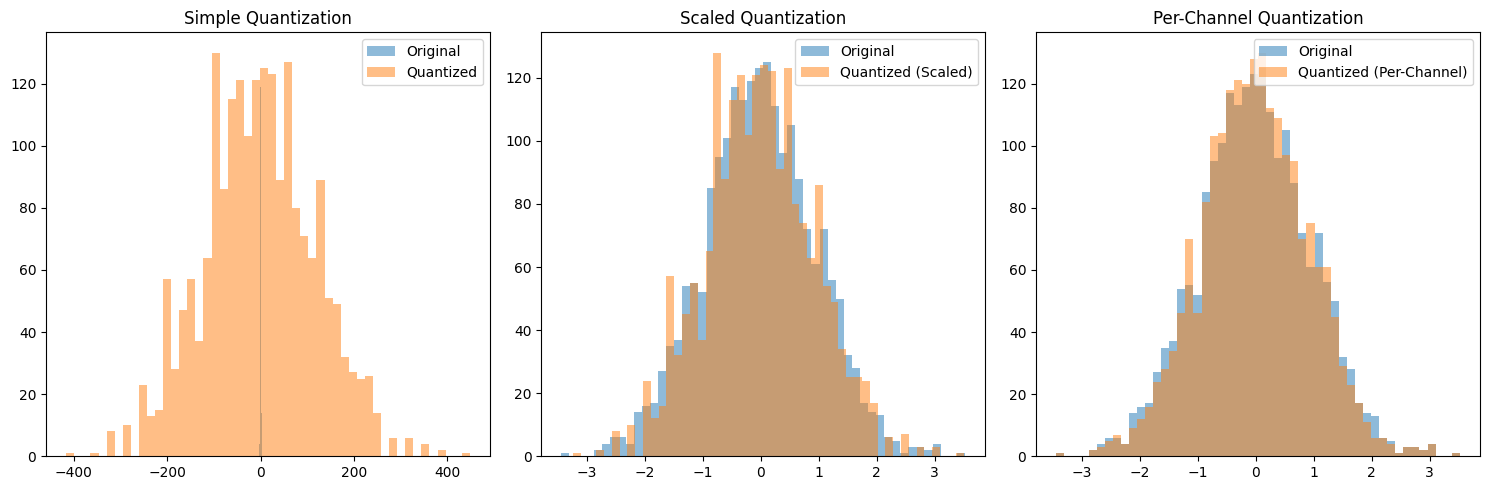


Quantization Errors (MSE):
Simple: 13467.875893
Scaled: 0.002479
Per-Channel: 0.002112


In [10]:
# Create a synthetic weight matrix
weights = np.random.normal(0, 1, (64, 32)).astype(
    np.float32
)  # 64 output features, 32 input features

# Simple quantization (no scaling)
quantized_simple = quantize_weights(weights, Float8)

# Quantization with automatic scaling
result_scaled = quantize_weights(weights, Float8, scale_factor=1.0)
quantized_scaled = result_scaled["weights"] * result_scaled["scale"]

# Per-channel quantization
result_per_channel = quantize_weights(weights, Float8, per_channel=True)
# Reshape scales to match output dimension
scales = result_per_channel["scales"].reshape(-1, 1)
quantized_per_channel = result_per_channel["weights"] * scales

# Plot weight distributions
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(weights.flatten(), bins=50, alpha=0.5, label="Original")
plt.hist(quantized_simple["weights"].flatten(), bins=50, alpha=0.5, label="Quantized")
plt.title("Simple Quantization")
plt.legend()

plt.subplot(132)
plt.hist(weights.flatten(), bins=50, alpha=0.5, label="Original")
plt.hist(quantized_scaled.flatten(), bins=50, alpha=0.5, label="Quantized (Scaled)")
plt.title("Scaled Quantization")
plt.legend()

plt.subplot(133)
plt.hist(weights.flatten(), bins=50, alpha=0.5, label="Original")
plt.hist(
    quantized_per_channel.flatten(), bins=50, alpha=0.5, label="Quantized (Per-Channel)"
)
plt.title("Per-Channel Quantization")
plt.legend()

plt.tight_layout()
plt.show()

# Print quantization errors
print("\nQuantization Errors (MSE):")
print(f"Simple: {np.mean((weights - quantized_simple["weights"])**2):.6f}")
print(f"Scaled: {np.mean((weights - quantized_scaled)**2):.6f}")
print(f"Per-Channel: {np.mean((weights - quantized_per_channel)**2):.6f}")

## 3. Analyzing Quantization Effects on Different Value Ranges

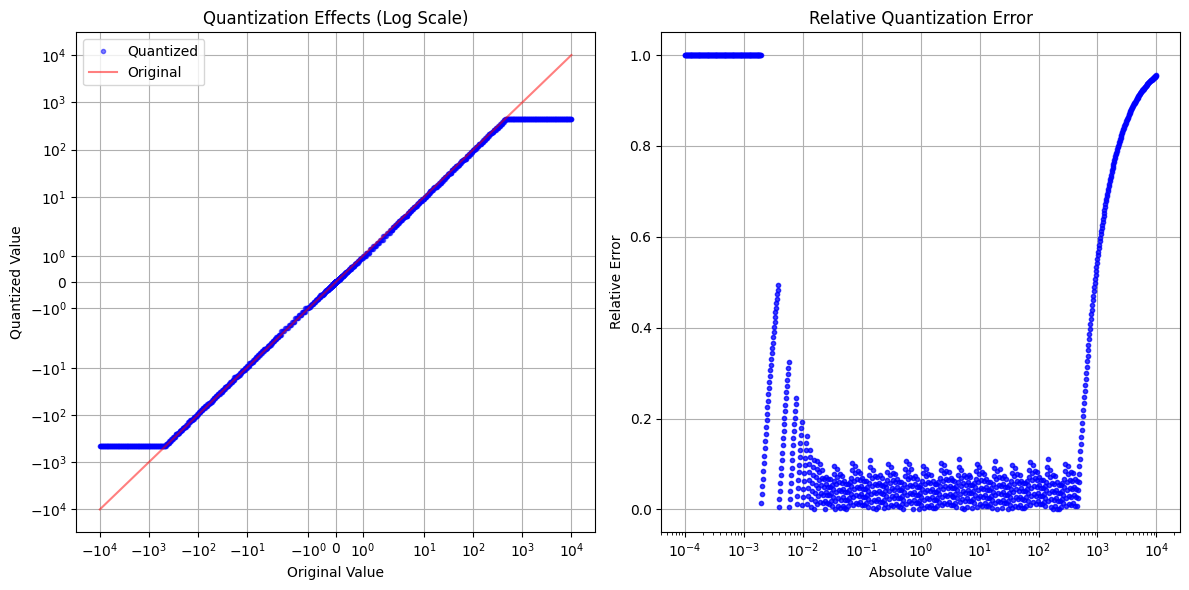

In [11]:
# Create values across different ranges
x = np.logspace(-4, 4, 1000)
values = np.concatenate([-x[::-1], [0], x])

# Quantize to Float8
quantized = np.array([float(Float8(v)) for v in values])

# Plot quantization effects
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(values, quantized, "b.", alpha=0.5, label="Quantized")
plt.plot(values, values, "r-", alpha=0.5, label="Original")
plt.xscale("symlog")
plt.yscale("symlog")
plt.grid(True)
plt.title("Quantization Effects (Log Scale)")
plt.xlabel("Original Value")
plt.ylabel("Quantized Value")
plt.legend()

plt.subplot(122)
rel_error = np.abs((quantized - values) / (values + 1e-10))
plt.semilogx(np.abs(values), rel_error, "b.", alpha=0.5)
plt.grid(True)
plt.title("Relative Quantization Error")
plt.xlabel("Absolute Value")
plt.ylabel("Relative Error")

plt.tight_layout()
plt.show()